In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 시계열 데이터 생성

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    
    # 싸인 곡선
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) 
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # 잡음
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [3]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

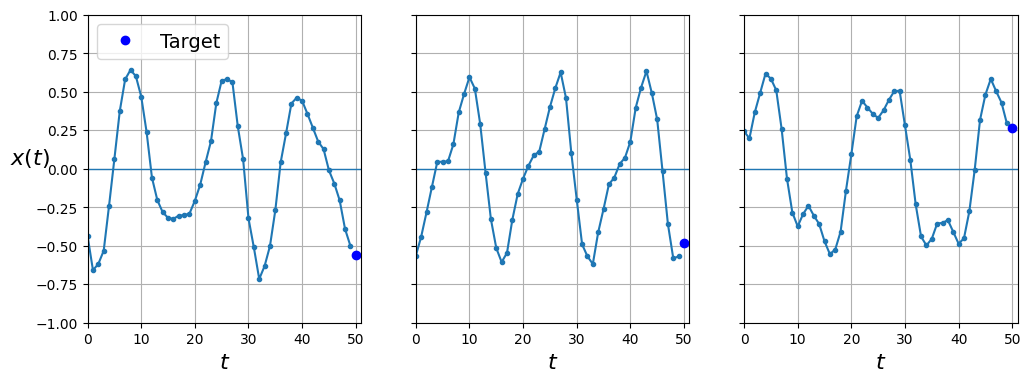

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

가장 간단한게 기준 성능을 정할 때 각 시계열 마지막 값을 그대로 예측하는 것을 순진한 예측이라고 한다.

In [5]:
# 순진한 예측

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.021453544

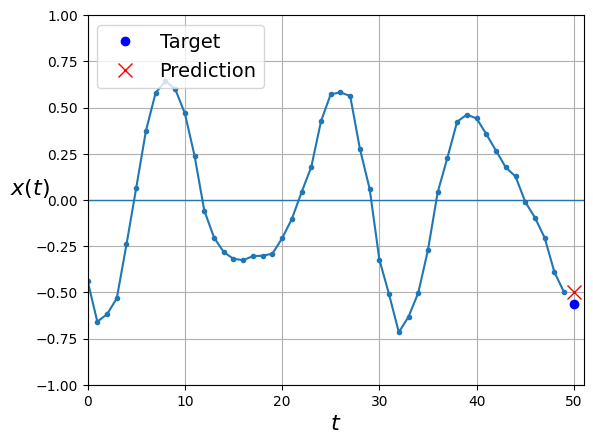

In [6]:
# 실제 값과 예측 값 비교
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [7]:
# 완전 연결 네트워크로 예측

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]), # 입력마다 1차원 특성 배열을 기대하기 때문에 추가
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.0702 - val_loss: 0.0289
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0180 - val_loss: 0.0112
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0040

0.0032343908678740263

완전 연결 네트워크를 사용하면 평균 제곱 오차가 0.02에서 0.004로 크게 감소하는것을 볼 수 있다.

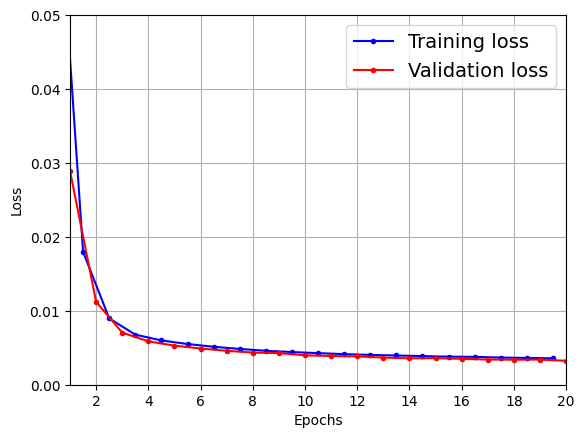

In [8]:
# 학습 결과 확인

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


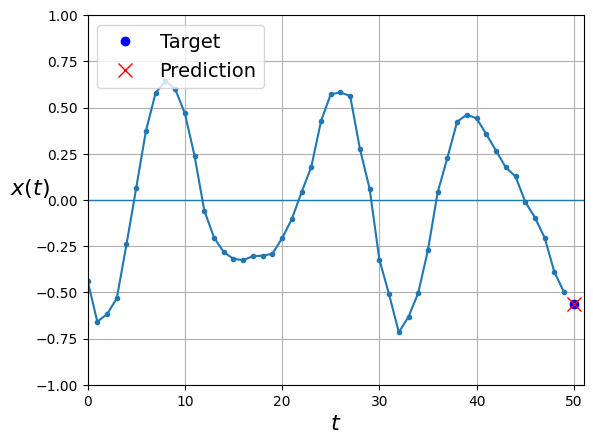

In [9]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [10]:
# 하나의 뉴런으로 이뤄진 RNN

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 5s 15ms/step - loss: 0.1121 - val_loss: 0.0396
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0313 - val_loss: 0.0270
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0228 - val_loss: 0.0209
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0183 - val_loss: 0.0173
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 8/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0114 - val_lo

0.01162295788526535

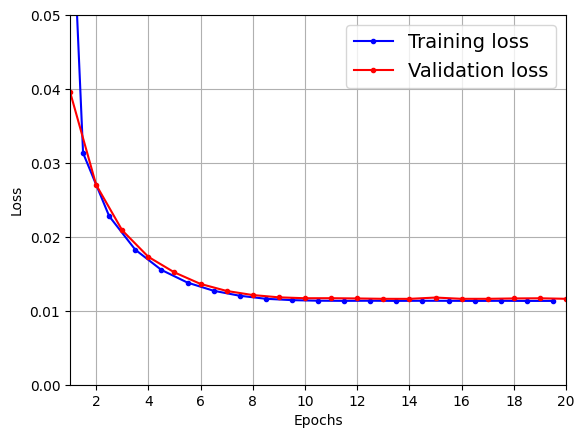

In [11]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 4ms/step


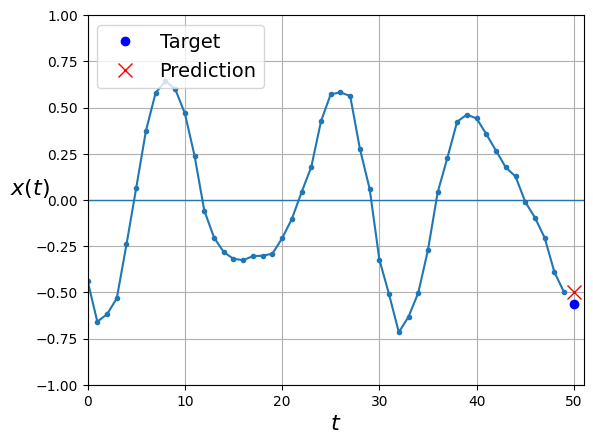

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

평균제곱 오차가 0.014가 나왔는데 이는 순진한 예측보다는 좋지만 간단한 선형모델보다 안좋은 성능이 나왔다.

In [13]:
# 심층 RNN

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 12s 30ms/step - loss: 0.0235 - val_loss: 0.0045
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 6/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0030 - val_l

0.0028956138994544744

순환 층을 더 쌓아 심층 RNN으로 학습하였더니 평균제곱 오차가 0.003이 나왔다.

따라서 심층 RNN이 선형 모델모다 더 좋은 성능을 낸다는 것을 볼 수 있다.

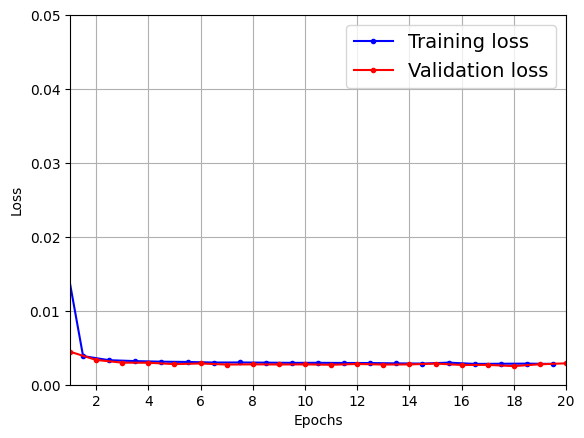

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 9ms/step


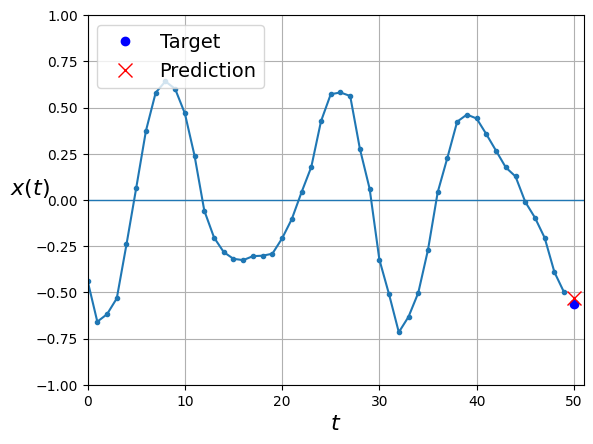

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

RNN에서 return_sequences를 True로 하지 않으면 마지막 타임 스텝의 출력만 담은 2차원 배열이 출력된다.

이런 경우 출력층을 Dense층으로 바꿔서 출력해야한다.

Dense층으로 출력층이 바뀌면 정확도는 비슷한데 속도는 더 빠르고 원하는 활성화 함수를 선택할 수 있다는 장점이 있다.

In [16]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 9s 19ms/step - loss: 0.0289 - val_loss: 0.0056
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0029 - val_lo

0.0025598653592169285

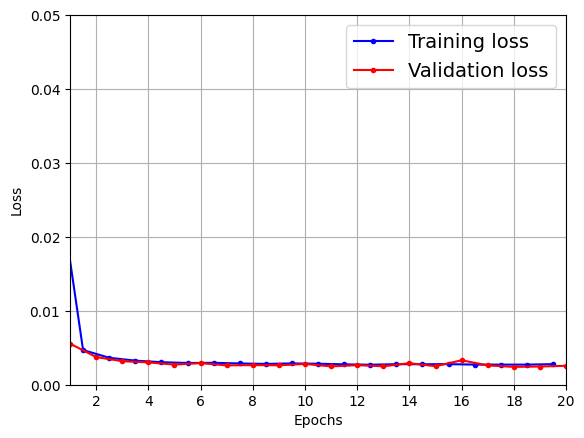

In [17]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 7ms/step


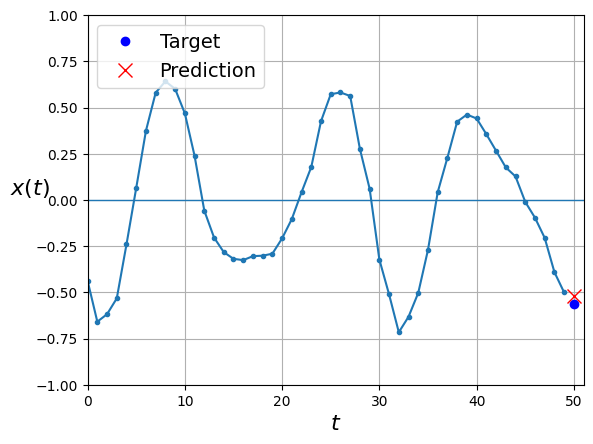

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [19]:
# 타깃을 바꿔 10스텝 앞의 값을 예측

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 24ms/step


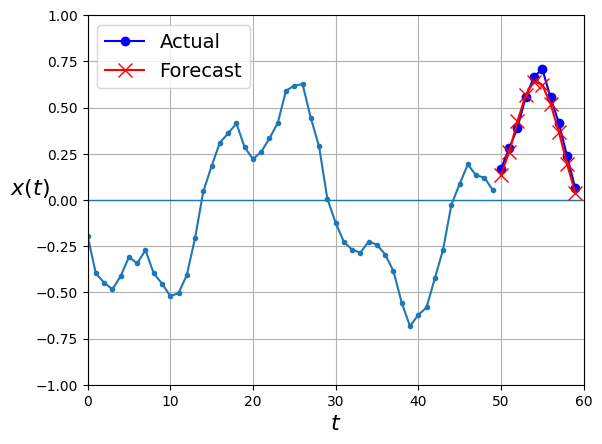

In [20]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [21]:
# 10스텝 앞의 값을 예측하기 위해 타깃을 10개의 값이 담긴 벡터로 생성

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [22]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 6ms/step


In [23]:
# 순진한 예측

Y_naive_pred = np.tile(X_valid[:, -1], 10) # 10번 반복
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25639468

In [24]:
# 선형 모델

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1256 - val_loss: 0.0666
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0531 - val_loss: 0.0455
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0403 - val_loss: 0.0375
Epoch 4/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0344 - val_loss: 0.0329
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0297
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0275
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0261
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0248
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0239
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0231

0.019453441724181175

In [25]:
# 심층 RNN

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 8s 15ms/step - loss: 0.0779 - val_loss: 0.0403
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0324 - val_loss: 0.0257
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0210 - val_loss: 0.0182
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0158 - val_loss: 0.0130
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0139 - val_loss: 0.0132
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0128 - val_loss: 0.0117
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0109 - val_loss: 0.0126
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0110 - val_lo

0.2778773009777069

1/1 [==============================] - 1s 637ms/step


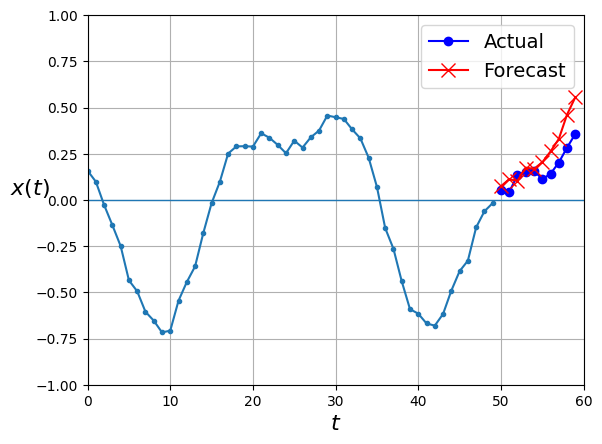

In [26]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

모든 데이터를 학습해 다음 10개의 스텝을 예측하는것이 아닌 매 순간 다음 10스텝을 예측하는 모델을 만들어본다.

이는 인과 모델로 어떤 타임 스텝에서 예측을 만들 때 과거 타임 스텝만 볼 수 있는 모델이다.

이 방식의 장점은 Sequence-to-Vector모델을 Sequence-to-Sequence로 바꿔 마지막 타임 스텝에서의 출력 뿐만 아니라 모든 타임 스텝에서 출력에 대한 손실을 볼 수 있어 훈련을 안정적으로 만들고 속도를 높이게 된다.

In [27]:
# RNN 인과 모델

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

TimeDistributed에서는 입력 시퀀스의 모든 타임 스텝에 Dense층을 적용시켜 각 타임스텝을 별개의 샘플처럼 다루도록 입력의 크기를 바꿔 효과적으로 수행한다.

In [28]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# 예측 & 평가는 마지막 타임 스텝의 출력만 사용함
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 8s 20ms/step - loss: 0.0467 - last_time_step_mse: 0.0360 - val_loss: 0.0387 - val_last_time_step_mse: 0.0266
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0349 - last_time_step_mse: 0.0228 - val_loss: 0.0329 - val_last_time_step_mse: 0.0208
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0311 - last_time_step_mse: 0.0189 - val_loss: 0.0311 - val_last_time_step_mse: 0.0195
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0275 - last_time_step_mse: 0.0152 - val_loss: 0.0270 - val_last_time_step_mse: 0.0144
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0240 - last_time_step_mse: 0.0114 - val_loss: 0.0235 - val_last_time_step_mse: 0.0096
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0221 - last_time_step_mse: 0.0095 - val_loss: 0.0211 - val_last_time_step_mse: 0.0078
Epoch 7/20
219/219 [==

[0.017638659104704857, 0.005897424649447203]

1/1 [==============================] - 0s 399ms/step


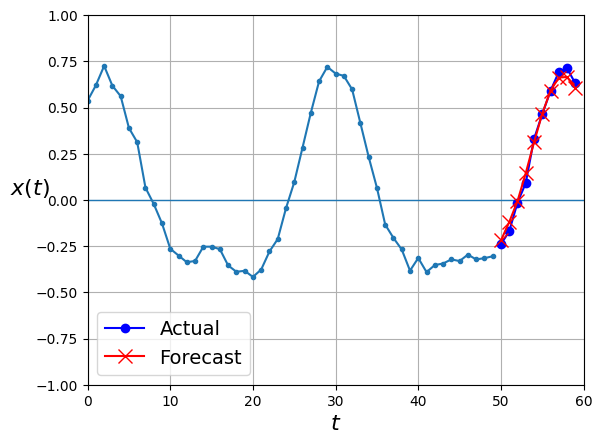

In [29]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [30]:
# 심층 RNN에 배치 정규화 적용

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 8s 19ms/step - loss: 0.1130 - last_time_step_mse: 0.1049 - val_loss: 0.0665 - val_last_time_step_mse: 0.0604
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0519 - last_time_step_mse: 0.0434 - val_loss: 0.0510 - val_last_time_step_mse: 0.0421
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0463 - last_time_step_mse: 0.0363 - val_loss: 0.0466 - val_last_time_step_mse: 0.0364
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0430 - last_time_step_mse: 0.0327 - val_loss: 0.0434 - val_last_time_step_mse: 0.0341
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0403 - last_time_step_mse: 0.0300 - val_loss: 0.0407 - val_last_time_step_mse: 0.0309
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0381 - last_time_step_mse: 0.0279 - val_loss: 0.0395 - val_last_time_step_mse: 0.0283
Epoch 7/20
219/219 [==

[0.028259780257940292, 0.016127536073327065]

배치 정규화를 사용해도 평균 제곱 오차가 유의미한 차이를 생성하지 못한것을 볼 수 있다.

오히려 결과가 더 않좋게 나오기 때문에 배치 정규화 방식은 RNN에서는 효과적이지 못하다는 것을 확인 할 수 있었다.

In [31]:
# 심층 RNN 에서 층 정규화 적용

from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [32]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 17s 46ms/step - loss: 0.1381 - last_time_step_mse: 0.1261 - val_loss: 0.0682 - val_last_time_step_mse: 0.0558
Epoch 2/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0593 - last_time_step_mse: 0.0479 - val_loss: 0.0548 - val_last_time_step_mse: 0.0431
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0504 - last_time_step_mse: 0.0389 - val_loss: 0.0479 - val_last_time_step_mse: 0.0365
Epoch 4/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0441 - last_time_step_mse: 0.0326 - val_loss: 0.0418 - val_last_time_step_mse: 0.0307
Epoch 5/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0388 - last_time_step_mse: 0.0268 - val_loss: 0.0375 - val_last_time_step_mse: 0.0246
Epoch 6/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0355 - last_time_step_mse: 0.0227 - val_loss: 0.0348 - val_last_time_step_mse: 0.0216
Epoch 7/20
219/219 [

[0.026160400360822678, 0.01263568364083767]

In [33]:
# 사용자 정의 RNN

class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [34]:
model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 15s 46ms/step - loss: 0.1673 - last_time_step_mse: 0.1428 - val_loss: 0.0772 - val_last_time_step_mse: 0.0643
Epoch 2/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0659 - last_time_step_mse: 0.0530 - val_loss: 0.0594 - val_last_time_step_mse: 0.0455
Epoch 3/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0548 - last_time_step_mse: 0.0418 - val_loss: 0.0523 - val_last_time_step_mse: 0.0379
Epoch 4/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0491 - last_time_step_mse: 0.0357 - val_loss: 0.0479 - val_last_time_step_mse: 0.0331
Epoch 5/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0446 - last_time_step_mse: 0.0304 - val_loss: 0.0430 - val_last_time_step_mse: 0.0280
Epoch 6/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0403 - last_time_step_mse: 0.0258 - val_loss: 0.0391 - val_last_time_step_mse: 0.0238
Epoch 7/20
219/21

[0.026790903881192207, 0.012066482566297054]

In [35]:
# LSTM

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 18s 45ms/step - loss: 0.0763 - last_time_step_mse: 0.0634 - val_loss: 0.0546 - val_last_time_step_mse: 0.0354
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0464 - last_time_step_mse: 0.0267 - val_loss: 0.0415 - val_last_time_step_mse: 0.0196
Epoch 3/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0382 - last_time_step_mse: 0.0178 - val_loss: 0.0366 - val_last_time_step_mse: 0.0156
Epoch 4/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0343 - last_time_step_mse: 0.0147 - val_loss: 0.0339 - val_last_time_step_mse: 0.0134
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0318 - last_time_step_mse: 0.0127 - val_loss: 0.0314 - val_last_time_step_mse: 0.0118
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0303 - last_time_step_mse: 0.0116 - val_loss: 0.0304 - val_last_time_step_mse: 0.0114
Epoch 7/20
219/219 [=

[0.023991433903574944, 0.008841349743306637]

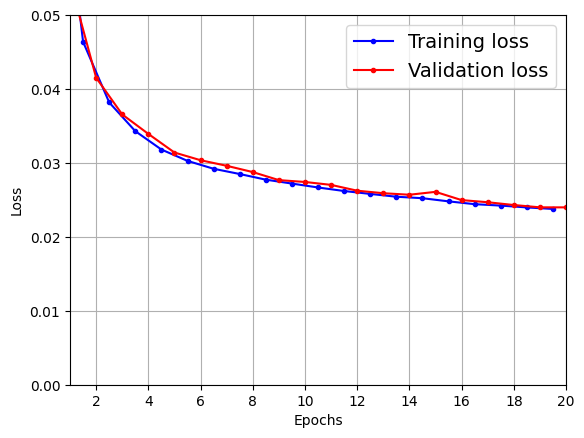

In [36]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 2s 2s/step


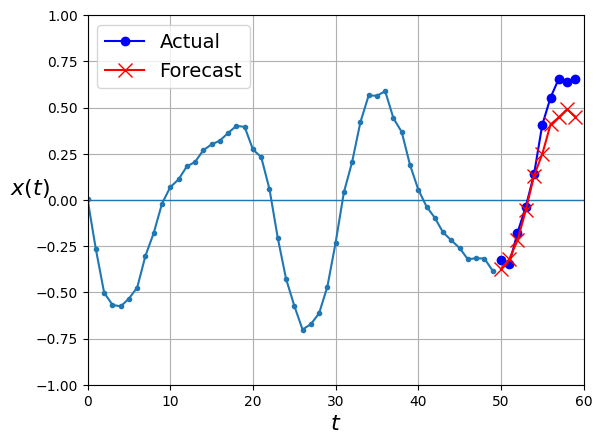

In [37]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [38]:
# GRU

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 20s 59ms/step - loss: 0.0769 - last_time_step_mse: 0.0703 - val_loss: 0.0539 - val_last_time_step_mse: 0.0436
Epoch 2/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0484 - last_time_step_mse: 0.0385 - val_loss: 0.0465 - val_last_time_step_mse: 0.0366
Epoch 3/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0428 - last_time_step_mse: 0.0324 - val_loss: 0.0409 - val_last_time_step_mse: 0.0302
Epoch 4/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0376 - last_time_step_mse: 0.0258 - val_loss: 0.0364 - val_last_time_step_mse: 0.0247
Epoch 5/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0341 - last_time_step_mse: 0.0220 - val_loss: 0.0340 - val_last_time_step_mse: 0.0218
Epoch 6/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0320 - last_time_step_mse: 0.0196 - val_loss: 0.0318 - val_last_time_step_mse: 0.0195
Epoch 7/20
219/2

[0.023700768128037453, 0.010199550539255142]

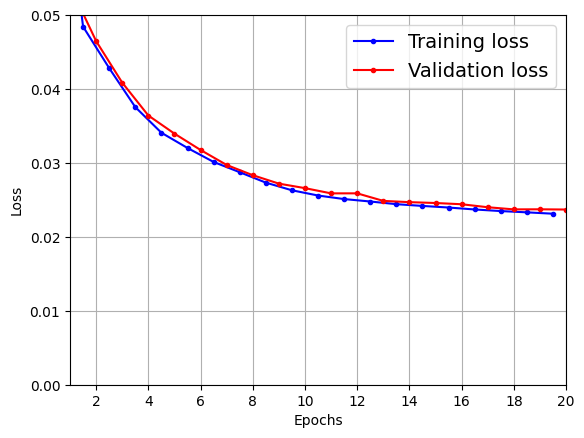

In [39]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 1s 1s/step


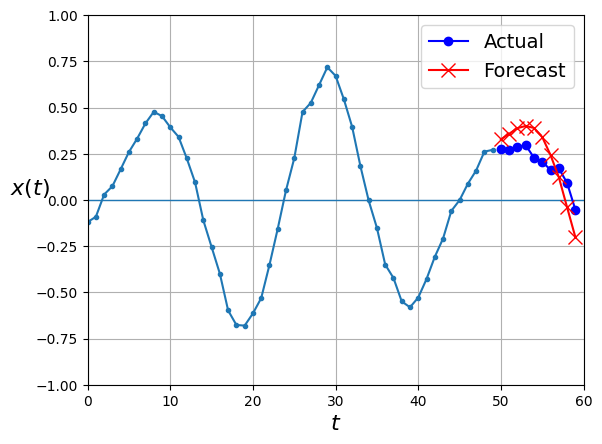

In [40]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [49]:
# 1D 합성곱 층 사용해 시퀀스 처리

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 15s 32ms/step - loss: 0.0709 - last_time_step_mse: 0.0638 - val_loss: 0.0496 - val_last_time_step_mse: 0.0405
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0406 - last_time_step_mse: 0.0331 - val_loss: 0.0361 - val_last_time_step_mse: 0.0284
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0323 - last_time_step_mse: 0.0239 - val_loss: 0.0304 - val_last_time_step_mse: 0.0210
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0279 - last_time_step_mse: 0.0176 - val_loss: 0.0270 - val_last_time_step_mse: 0.0159
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0251 - last_time_step_mse: 0.0142 - val_loss: 0.0247 - val_last_time_step_mse: 0.0133
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0235 - last_time_step_mse: 0.0125 - val_loss: 0.0235 - val_last_time_step_mse: 0.0118
Epoch 7/20
219/219 [=

In [42]:
# WaveNet구조로 시퀀스 처리

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

# 층마다 팽창  비율 2배
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

model.evaluate(X_valid, Y_valid)

Epoch 1/20
219/219 [==============================] - 8s 18ms/step - loss: 0.0668 - last_time_step_mse: 0.0541 - val_loss: 0.0378 - val_last_time_step_mse: 0.0227
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0320 - last_time_step_mse: 0.0187 - val_loss: 0.0293 - val_last_time_step_mse: 0.0163
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0278 - last_time_step_mse: 0.0152 - val_loss: 0.0272 - val_last_time_step_mse: 0.0143
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0260 - last_time_step_mse: 0.0136 - val_loss: 0.0256 - val_last_time_step_mse: 0.0129
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0249 - last_time_step_mse: 0.0127 - val_loss: 0.0255 - val_last_time_step_mse: 0.0134
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0241 - last_time_step_mse: 0.0120 - val_loss: 0.0238 - val_last_time_step_mse: 0.0114
Epoch 7/20
219/219 [==

[0.020231546834111214, 0.008296599611639977]

In [43]:
# 논문에 정의된 원본 WaveNet

class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate
    
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [47]:
n_layers_per_block = 3
n_blocks = 1
n_filters = 32
n_outputs = 10

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 10s 21ms/step - loss: 0.1289 - last_time_step_mse: 0.1250 - val_loss: 0.1231 - val_last_time_step_mse: 0.1201
Epoch 2/2
219/219 [==============================] - 4s 18ms/step - loss: 0.1222 - last_time_step_mse: 0.1179 - val_loss: 0.1221 - val_last_time_step_mse: 0.1191
